## Лабораторна робота №2: "Імплементація алгоритмів стиснення"

Склад команди та розподіл виконаних завдань:

- Остап Павлишин - Алгоритм Гаффмана, алгоритм LZW
- Максим-Василь Тарнавський - Алгоритм LZ77, алгоритм Deflate

Для кожного з алгоритмів поданих нижче
- опишіть як працює алгорит
- напишіть класи з методами encode та decode
- перевірте правильність кодування та декодування
- дослідіть час виконання коду в залежності від розмірів вхідних даних
- оцініть ступінь стиснення(у відсотка) в залежності від розмірів
- напишіть висновок про ефективність різних алгоритмів та умови за яких той чи інший алгоритм дають кращий результат

# Алгоритм Гаффмана

В цьому алгоритмі доцільно імплементувати клас node та додаткові функції в Huffman для побудови дерева кодування

In [1]:
import heapq

class Node:
    def __init__(self, frequency, name=None, left=None, right=None):
        self.frequency = frequency
        self.name = name
        self.left = left
        self.right = right
        self.code = None
    
    def __lt__(self, other):
        return self.frequency < other.frequency

class Huffman:
    def build_tree(self, probabilities):
        pq = [Node(probability, name) for name, probability in probabilities.items()]
        heapq.heapify(pq)
        while len(pq) > 1:
            x = heapq.heappop(pq)
            y = heapq.heappop(pq)
            z = Node(x.frequency + y.frequency, left=x, right=y)
            heapq.heappush(pq, z)
        return pq[0]

    def encode(self, text: str) -> tuple[str, dict[str, str]]:
        probabilities = {letter: text.count(letter)/len(text) for letter in set(text)}
        root = self.build_tree(probabilities)

        codes = {}
        self.generate_huffman_codes(root, '', codes)

        result = ''.join(codes[el] for el in text)

        return result, codes

    def generate_huffman_codes(self, node, code, codes):
        if node.left is None and node.right is None:
            codes[node.name] = code
        else:
            self.generate_huffman_codes(node.left, code + '0', codes)
            self.generate_huffman_codes(node.right, code + '1', codes)

    def decode(self, code: str, coding_dict: dict[str, str]):
        result = ''
        new_dict = {value:key for key, value in coding_dict.items()}
        while len(code) >= 1:
            word = ''
            i = 0
            while word not in new_dict:
                word += code[i]
                i += 1
            result += new_dict[word]
            code = code[i:]
        return result
    

# Висновок:

Алгоритм Гаффмана зазвичай краще підходить для текстів з високою частотою повторення конкретних символів або знаків. Він добре працює, коли в даних є надлишковість. Разом з тим, він все ж не такий залежний від великої кількості повторів, як lz-коди. Порівняно з іншими кодами, він видає набагато стабільніші, хоч і не особливо високі, результати. Він також є швидшим, ніж більшість інших алгоритмів у цій лабораторній.

# Алгоритм LZW

In [2]:
class LZW:
    def encode(self, text: str) -> tuple[str, list]:
        new_text = text
        result = ''
        uniqueness_first = {}
        i = 0
        for letter in text:
            if letter not in uniqueness_first:
                uniqueness_first[letter] = i
                i += 1
        uniqueness = uniqueness_first.copy()
        while len(new_text) >= 2:
            k = 1
            word = new_text[0]
            while word in uniqueness and k < len(text):
                word += new_text[k]
                k += 1
            if word not in uniqueness:
                uniqueness[word] = len(uniqueness.items())
            result += str(uniqueness[word[:-1]]) + ','
            new_text = new_text[len(word)-1:]
            if new_text in uniqueness:
                result += str(uniqueness[new_text])
                new_text = ''
        return result, list(uniqueness_first.keys())

    def decode(self, code: str, coding_dict: list) -> str:
        new_code = {i:key for i, key in enumerate(coding_dict)}
        decoded_string = ""
        prev_code = None
        code = list(map(lambda x: int(x), code.split(',')))
        
        for c in code:
            if prev_code is None:
                decoded_string += new_code[c]
                prev_code = c
            else:
                if c < len(new_code):
                    entry = new_code[c]
                else:
                    entry = new_code[prev_code] + new_code[prev_code][0]

                decoded_string += entry
                new_code[len(new_code)] = new_code[prev_code] + entry[0]
                prev_code = c
        
        return decoded_string

# Висновок

LZW, як правило, найкраще справляється з текстами, що містять повторювані шаблони або довгі повторювані послідовності. Він часто ефективніший за алгоритм Гаффмана, коли в тексті є довгі повторювані підрядки або фрази. Хоч результати LZW не настільки стабільні, як алгоритму Гаффмана, він все ж залежить від довжини повідомлення набагато менше, ніж наступні алгоритми. За швидкістю він також не поступається алгоритму Гаффмана.

# Алгоритм LZ77

Потрібно заміряти розміри саме тексту, проте для роботи доцільно використовувати список тюплів, тому для зручності варто імплементувати додаткові алгоритми _text2list та _list2text

In [3]:
class LZ77:
    def __init__(self, buffer_size: int):
        self.buffer_size = buffer_size
    
    def _text2list(self, text: str) -> list[tuple[int, int, str]]:
        '''
        Change the text representation of a LZ77 code
        back to a list of tuples.
        '''
        if text[-1] == '~':
            return [(int(tup.split('~')[0]), int(tup.split('~')[1]), tup.split('~')[2])\
             for tup in text.split('|')[:-1]] + [(int(text.split('|')[-1].split('~')[0]), int(text.split('|')[-1].split('~')[1]), '')]
        return [(int(tup.split('~')[0]), int(tup.split('~')[1]), tup.split('~')[2])\
             for tup in text.split('|')]


    def _list2text(self, code: list[tuple[int, int, str]])-> str:
        '''
        Represent a LZ77 code as a text for
        comapring purposes.
        '''
        
        return '|'.join('~'.join(str(elem) for elem in tup) for tup in code)


    def find_best_match(self, cur_ind: int, text: str) -> tuple[int, int, str]:
        '''
        Helper function that finds the best match for
        a given character in the buffer.
        '''
        
        buffer = text[max(0, cur_ind - self.buffer_size):cur_ind]

        if not text[cur_ind] in buffer:
            return (0, 0, text[cur_ind])
        
        possib = [ind for ind, elem in enumerate(buffer) if elem == text[cur_ind]]
        possib = [len(buffer) - elem for elem in possib]

        best_match = (0, 0, '')

        for offset in possib:
            buffer = text[max(0, cur_ind - self.buffer_size):cur_ind]

            for length in range(len(text) - cur_ind):

                if text[cur_ind + length] != buffer[len(buffer) - offset]:
                    break

                buffer = (buffer + text[cur_ind + length])[-self.buffer_size:]

            if cur_ind + length + 1 == len(text):

                    best_match = (offset, length + 1, '') if text[-1]\
                     == text[-offset-1] else (offset, length, text[-1])
                    break

            if length >= best_match[1]:

                    best_match = (offset, length, text[cur_ind + length])
        
        return best_match


    def encode(self, text: str) -> str:
        '''
        Encode a given text using LZ77 algorithm.
        '''
        result = []
        cur_ind = 0

        while cur_ind < len(text):

            offset, length, next_char = self.find_best_match(cur_ind, text)
            cur_ind += length + 1
            result.append((offset, length, next_char))
        
        return self._list2text(result)


    def decode(self, code: str) -> str:
        '''
        Decode a given code created with LZ77 algorithm.
        '''
        code = self._text2list(code)

        result = ''
        for offset, length, next_char in code:

            for _ in range(length):
                result += result[-offset]
            result += next_char
        
        return result


# Висновок

LZ77, як і LZW, проявляє найкращі результати за наявності великої кількості повторюваних послідовностей. Він, напевно, найбільше залежить від довжини повідомлення, особливо за відносно невеликих розмірів буфера. Разом з тим, при достатньо великому буфері він переганяє LZW по ефективності. З іншого боку, LZ77 дещо поступається швидкістю попереднім алгоритмам.

# Алгоритм Deflate

In [4]:
class Deflate:
    def __init__(self, buffer_size: int):
        self.lz77 = LZ77(buffer_size)
        self.huffman = Huffman()

    def encode(self, text: str) -> str:
        lz77_code = self.lz77.encode(text)
        return self.huffman.encode(lz77_code)

    def decode(self, code: str, coding_dict: dict[str, str]) -> str:

        lz77_code = self.huffman.decode(code, coding_dict)
        return self.lz77.decode(lz77_code)


# Висновок

Deflate - поєднання LZ77 та алгоритму Гаффмана. Його ефективність, як і ефективність LZ77, досить сильно залежить від довжини коду й буфера, проте за достатньо великих розмірів цих показників він є найефективнішим з усіх алгоритмів. Також, як і LZ77, він показує найкращі результати при роботі з текстами з великою кількістю повторюваних послідовнестей. Оскільки він є поєднанням двох алгоритмів, не дивно, що Deflate також виявився найповільнішим з них.

# Оцінка швидкості

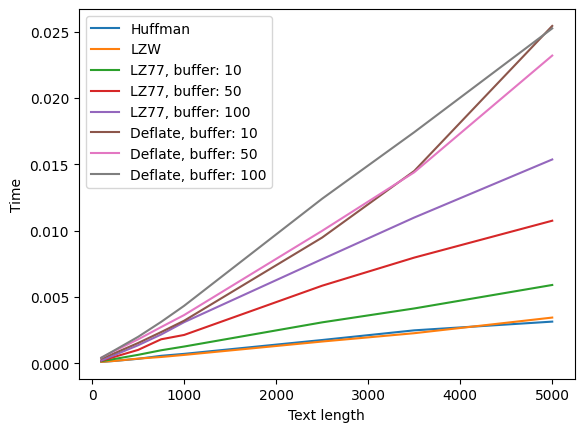

In [5]:
from timeit import default_timer as timer
import matplotlib.pyplot as plt


def eval_time(alg: object, buffer: int = None):
    '''
    Evaluate the compression ratio of a given algorithm
    for a given text length.
    '''
    algorithm = alg(buffer) if buffer else alg()

    result = {}

    test_str = 'Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam erat, sed diam voluptua. At vero eos et accusam et justo duo dolores et ea rebum. Stet clita kasd gubergren, no sea takimata sanctus est Lorem ipsum dolor sit amet. Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam erat, sed diam voluptua. At vero eos et accusam et justo duo dolores et ea rebum. Stet clita kasd gubergren, no sea takimata sanctus est Lorem ipsum dolor sit amet. Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam erat, sed diam voluptua. At vero eos et accusam et justo duo dolores et ea rebum. Stet clita kasd gubergren, no sea takimata sanctus est Lorem ipsum dolor sit amet. Duis autem vel eum iriure dolor in hendrerit in vulputate velit esse molestie consequat, vel illum dolore eu feugiat nulla facilisis at vero eros et accumsan et iusto odio dignissim qui blandit praesent luptatum zzril delenit augue duis dolore te feugait nulla facilisi. Lorem ipsum dolor sit amet, consectetuer adipiscing elit, sed diam nonummy nibh euismod tincidunt ut laoreet dolore magna aliquam erat volutpat. Ut wisi enim ad minim veniam, quis nostrud exerci tation ullamcorper suscipit lobortis nisl ut aliquip ex ea commodo consequat. Duis autem vel eum iriure dolor in hendrerit in vulputate velit esse molestie consequat, vel illum dolore eu feugiat nulla facilisis at vero eros et accumsan et iusto odio dignissim qui blandit praesent luptatum zzril delenit augue duis dolore te feugait nulla facilisi. Nam liber tempor cum soluta nobis eleifend option congue nihil imperdiet doming id quod mazim placerat facer possim assum. Lorem ipsum dolor sit amet, consectetuer adipiscing elit, sed diam nonummy nibh euismod tincidunt ut laoreet dolore magna aliquam erat volutpat. Ut wisi enim ad minim veniam, quis nostrud exerci tation ullamcorper suscipit lobortis nisl ut aliquip ex ea commodo consequat. Duis autem vel eum iriure dolor in hendrerit in vulputate velit esse molestie consequat, vel illum dolore eu feugiat nulla facilisis. At vero eos et accusam et justo duo dolores et ea rebum. Stet clita kasd gubergren, no sea takimata sanctus est Lorem ipsum dolor sit amet. Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam erat, sed diam voluptua. At vero eos et accusam et justo duo dolores et ea rebum. Stet clita kasd gubergren, no sea takimata sanctus est Lorem ipsum dolor sit amet. Lorem ipsum dolor sit amet, consetetur sadipscing elitr, At accusam aliquyam diam diam dolore dolores duo eirmod eos erat, et nonumy sed tempor et et invidunt justo labore Stet clita ea et gubergren, kasd magna no rebum. sanctus sea sed takimata ut vero voluptua. est Lorem ipsum dolor sit amet. Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam erat. Consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam erat, sed diam voluptua. At vero eos et accusam et justo duo dolores et ea rebum. Stet clita kasd gubergren, no sea takimata sanctus est Lorem ipsum dolor sit amet. Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam erat, sed diam voluptua. At vero eos et accusam et justo duo dolores et ea rebum. Stet clita kasd gubergren, no sea takimata sanctus est Lorem ipsum dolor sit amet. Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam erat, sed diam voluptua. At vero eos et accusam et justo duo dolores et ea rebum. Stet clita kasd gubergren, no sea takimata sanctus. Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam erat, sed diam voluptua. At vero eos et accusam et justo duo dolores et ea rebum. Stet clita kasd gubergren, no sea takimata sanctus est Lorem ipsum dolor sit amet. Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam erat, sed diam voluptua. At vero eos et accusam et justo duo dolores et ea rebum. Stet clita kasd gubergren, no sea takimata sanctus est Lorem ipsum dolor sit amet. Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam erat, sed diam voluptua. At vero eos et accusam et justo duo dolores et ea rebum. Stet clita kasd gubergren, no sea takimata sanctus est Lorem ipsum dolor sit amet. Duis autem vel eum iriure dolor in hendrerit in vulputate velit esse molestie consequat, vel illum dolore eu feugiat nulla facilisis at vero eros et accumsan et iusto '

    for text_len in (100, 250, 500, 750, 1000, 2500, 3500, 5000):

        if alg == LZ77:
            start = timer()
            algorithm.decode(algorithm.encode(test_str[:text_len]))
            end = timer()

        else:
            start = timer()
            algorithm.decode(*algorithm.encode(test_str[:text_len]))
            end = timer()



        result[text_len] = end - start
        
    return result



for alg in [Huffman, LZW, LZ77, Deflate]:
    if alg in (LZ77, Deflate):
        for buffer in (10, 50, 100):
            times = eval_time(alg, buffer)
            plt.plot(list(times.keys()), list(times.values()), label=f'{alg.__name__}, buffer: {buffer}')
            plt.legend()
    else:
        times = eval_time(alg)
        plt.plot(list(times.keys()), list(times.values()), label=alg.__name__)
        plt.xlabel('Text length')
        plt.ylabel('Time')
        plt.legend()

# Оцінка стиснення

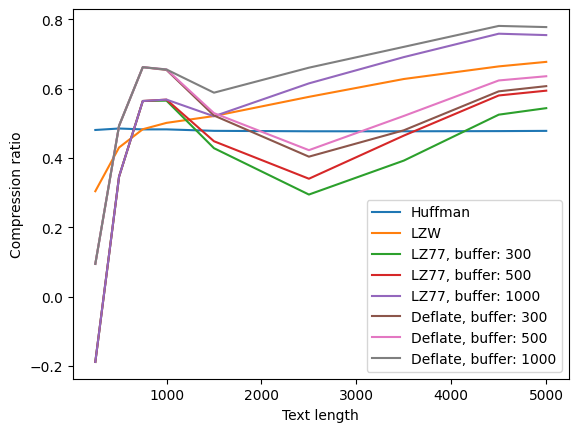

In [6]:
test_str = 'Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam erat, sed diam voluptua. At vero eos et accusam et justo duo dolores et ea rebum. Stet clita kasd gubergren, no sea takimata sanctus est Lorem ipsum dolor sit amet. Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam erat, sed diam voluptua. At vero eos et accusam et justo duo dolores et ea rebum. Stet clita kasd gubergren, no sea takimata sanctus est Lorem ipsum dolor sit amet. Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam erat, sed diam voluptua. At vero eos et accusam et justo duo dolores et ea rebum. Stet clita kasd gubergren, no sea takimata sanctus est Lorem ipsum dolor sit amet. Duis autem vel eum iriure dolor in hendrerit in vulputate velit esse molestie consequat, vel illum dolore eu feugiat nulla facilisis at vero eros et accumsan et iusto odio dignissim qui blandit praesent luptatum zzril delenit augue duis dolore te feugait nulla facilisi. Lorem ipsum dolor sit amet, consectetuer adipiscing elit, sed diam nonummy nibh euismod tincidunt ut laoreet dolore magna aliquam erat volutpat. Ut wisi enim ad minim veniam, quis nostrud exerci tation ullamcorper suscipit lobortis nisl ut aliquip ex ea commodo consequat. Duis autem vel eum iriure dolor in hendrerit in vulputate velit esse molestie consequat, vel illum dolore eu feugiat nulla facilisis at vero eros et accumsan et iusto odio dignissim qui blandit praesent luptatum zzril delenit augue duis dolore te feugait nulla facilisi. Nam liber tempor cum soluta nobis eleifend option congue nihil imperdiet doming id quod mazim placerat facer possim assum. Lorem ipsum dolor sit amet, consectetuer adipiscing elit, sed diam nonummy nibh euismod tincidunt ut laoreet dolore magna aliquam erat volutpat. Ut wisi enim ad minim veniam, quis nostrud exerci tation ullamcorper suscipit lobortis nisl ut aliquip ex ea commodo consequat. Duis autem vel eum iriure dolor in hendrerit in vulputate velit esse molestie consequat, vel illum dolore eu feugiat nulla facilisis. At vero eos et accusam et justo duo dolores et ea rebum. Stet clita kasd gubergren, no sea takimata sanctus est Lorem ipsum dolor sit amet. Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam erat, sed diam voluptua. At vero eos et accusam et justo duo dolores et ea rebum. Stet clita kasd gubergren, no sea takimata sanctus est Lorem ipsum dolor sit amet. Lorem ipsum dolor sit amet, consetetur sadipscing elitr, At accusam aliquyam diam diam dolore dolores duo eirmod eos erat, et nonumy sed tempor et et invidunt justo labore Stet clita ea et gubergren, kasd magna no rebum. sanctus sea sed takimata ut vero voluptua. est Lorem ipsum dolor sit amet. Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam erat. Consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam erat, sed diam voluptua. At vero eos et accusam et justo duo dolores et ea rebum. Stet clita kasd gubergren, no sea takimata sanctus est Lorem ipsum dolor sit amet. Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam erat, sed diam voluptua. At vero eos et accusam et justo duo dolores et ea rebum. Stet clita kasd gubergren, no sea takimata sanctus est Lorem ipsum dolor sit amet. Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam erat, sed diam voluptua. At vero eos et accusam et justo duo dolores et ea rebum. Stet clita kasd gubergren, no sea takimata sanctus. Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam erat, sed diam voluptua. At vero eos et accusam et justo duo dolores et ea rebum. Stet clita kasd gubergren, no sea takimata sanctus est Lorem ipsum dolor sit amet. Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam erat, sed diam voluptua. At vero eos et accusam et justo duo dolores et ea rebum. Stet clita kasd gubergren, no sea takimata sanctus est Lorem ipsum dolor sit amet. Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam erat, sed diam voluptua. At vero eos et accusam et justo duo dolores et ea rebum. Stet clita kasd gubergren, no sea takimata sanctus est Lorem ipsum dolor sit amet. Duis autem vel eum iriure dolor in hendrerit in vulputate velit esse molestie consequat, vel illum dolore eu feugiat nulla facilisis at vero eros et accumsan et iusto '

def get_clean_deflate(code: str, coding_dict: dict[str, str])-> str:
    '''
    Get Deflate code without "~" and "|" characters.
    '''
    result = ''
    new_dict = {value:key for key, value in coding_dict.items()}
    while len(code) >= 1:
        word = ''
        i = 0
        while word not in new_dict:
            word += code[i]
            i += 1
        if not new_dict[word] in ('~', '|'):
            result += word
        code = code[i:]
    return result



def eval_compression(alg: object, buffer: int = None)-> float:

    algorithm = alg(buffer) if buffer else alg()

    result = {}

    for text_len in (250, 500, 750, 1000, 1500, 2500, 3500, 4500, 5000):

        if isinstance(algorithm, LZ77):

            code = algorithm.encode(test_str[:text_len]).split('|')
            result[text_len] = 1 - 3 * len(code) / text_len

        elif isinstance(algorithm, LZW):

            result[text_len] = 1 - len(algorithm.encode(test_str[:text_len])[0].split(','))/text_len

        else:

            res = ''.join(f'{ord(i):08b}' for i in test_str[:text_len])

            result[text_len] =  1 - len(get_clean_deflate(*algorithm.encode(test_str[:text_len])))/len(res)

    return result



for alg in [Huffman, LZW, LZ77, Deflate]:
    if alg in (LZ77, Deflate):
        for buffer in (300, 500, 1000):
            times = eval_compression(alg, buffer)
            plt.plot(list(times.keys()), list(times.values()), label=f'{alg.__name__}, buffer: {buffer}')
            plt.legend()
    else:
        times = eval_compression(alg)
        plt.plot(list(times.keys()), list(times.values()), label=alg.__name__)
        plt.xlabel('Text length')
        plt.ylabel('Compression ratio')
        plt.legend()

# Загальний висновок

В цій лабораторній ми розглянули декілька найбазовіших алгоритмів стиску: Huffman, LZ77, LZW та Deflate. За результатами досліду виявилося, що найшвидшими алгоритмами є LZW та Huffman, а найефективнішими - LZ77 та Deflate. Також можна сказати, що для відносно малих повідомлень найкращим алгоритмом є Huffman. Також він є найефективнішим в ситуаціях, коли повторюються саме окремі символи, а не довші послідовності. Інші ж алгоритми найкраще показують себе в другому випадку, зокрема ефективність серед них виділяється Deflate.